# Assignment 12

In this tutorium, we will work on GANs networks (https://arxiv.org/pdf/1406.2661.pdf). This kind of network is part of the generative networks who are actually able to generate synthetic data. This network is actually composed of two, a generator responsible for generate fake data and a discriminator for investigating on the trueness of the images.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pathmind.com/images/wiki/GANs.png", width=700)

The disciminator can be see as a very simple fully connected network, composed of several layer of neurons and a simple output of one neurone who just determine if a image is true or false.

The generator looks more like the upscaling part of the segmenetation network. A small piece of noise is injected and the output is an images. 

The training is maybe the most original part. 

First, you train the discriminator alone by injecting the training set (True data so label=True) and a set of data generated by the generator (label=False) you then have a loss to back propagate. *Applause, you trained you discriminator for one batch*

Second, you inject some noise in your generator, the generator produce some fake images, you inject this fake images in you discriminator and use the labels generated by the discriminator to compute your backpropagation. So to train your generator, you will consider the generator and the discriminator as the same network, you just don't train the discriminator in this case.

## 12.1

We ask you then to program you own GANs. this network should be just compose of fully connected layer (no conv). You should define the architecture of the network, then provide two training function one for the generator and one for the discriminator and make him learn!

We will take the MNIST dataset here for simplicity and lightness. The architecture I used was :

G : (Input : random Tensor = 100) => (FC1 : fully connected = 256) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 784) =>  (Tanh)

D : (Input : flatten images Tensor = 784) => (FC1 : fully connected = 1024) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 1) =>  (Sigmoid)

This architecture is what I use, it's working but not great, so feel free to change it!!

The training is 20-30min on a 1060 6Go for 100 epochs and batch size of 100. Here, it's a little bit different than before, the loss do not necessarly go done, it's a race between D and G so both cannot be good at the same time.

In [30]:
# Hyper parameters
GENERATOR_INPUT_SIZE = 100
BATCH_SIZE = 100
LEARNING_RATE_G = 0.01
LEARNING_RATE_D = 0.01
MOMENTUM_G = 0.5
MOMENTUM_D = 0.5
# n_epochs = 3
# batch_size_train = 10
# batch_size_test = 1000
# log_interval = 10

# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

In [31]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

# If Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image processing
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# MNIST dataset
train_mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_mnist,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

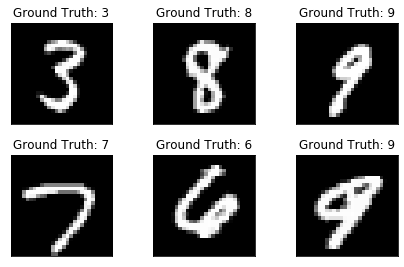

In [32]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [33]:
class Discriminator(nn.Module):
    """
    D :
    (Input : flatten images Tensor = 784)
    => (FC1 : fully connected = 1024)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 512)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC3 : fully connected = 1)
    => (Sigmoid)
    """
    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(28**2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            # Not more than 25%, http://iamtrask.github.io/2015/07/28/dropout/
            nn.Dropout(p=0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        print(img.shape)
        flattened_img = img.view(img.size(0), -1)
        return self.seq(flattened_img)


class Generator(nn.Module):
    """
    G :
    (Input : random Tensor = 100)
    => (FC1 : fully connected = 256)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 512)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 784)
    => (Tanh)
    """
    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(GENERATOR_INPUT_SIZE, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            # Not more than 25%, http://iamtrask.github.io/2015/07/28/dropout/
            nn.Dropout(p=0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.seq(x)

In [34]:
# Loss function:
# In the paper, the GAN corresponds to a minimax 2-player game.
# As of
# https://developers.google.com/machine-learning/gan/loss#minimax-loss
# "Tthe formula derives from the cross-entropy between the real and generated distributions."
# Thus, we use a cross-entropy loss function pytorch provides:
# adversarial_loss = nn.CrossEntropyLoss()
# adversarial_loss = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

G = Generator()
D = Discriminator()

G.to(device)
D.to(device)
criterion.to(device)

# Optimizers
# optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer_G = optim.SGD(G.parameters(), lr=LEARNING_RATE_G, momentum=MOMENTUM_G)
optimizer_D = optim.SGD(D.parameters(), lr=LEARNING_RATE_D, momentum=MOMENTUM_D)

In [35]:
def train(epochs=30, k=1):
    """
    Algorithm 1:
    Minibatch stochastic gradient descent training of generative adversarial nets.
    The number of steps to apply to the discriminator, k, is a hyperparameter.
    We used k = 1, the least expensive option, in our experiments.
    
    for number of training iterations do
        for k steps do
            • Sample minibatch of m noise samples {z(1), ... , z(m)} from noise prior pg(z).
            • Sample minibatch of m examples {x(1), ... , x(m)} from data generating distribution pdata (x).
            • Update the discriminator by ascending its stochastic gradient
        end for
        • Sample minibatch of m noise samples {z(1), . . . , z(m)} from noise prior pg(z).
        • Update the generator by descending its stochastic gradient
    end for

    The gradient-based updates can use any standard gradient-based learning rule.
    We used momentum in our experiments.
    
    ======================================================================
    
    The training is maybe the most original part:
    First, you train the discriminator alone by injecting the training set (True data so label=True)
    and a set of data generated by the generator (label=False) you then have a loss to back propagate.
    Applause, you trained you discriminator for one batch.
    Second, you inject some noise in your generator, the generator produce some fake images.
    You inject these fake images into your discriminator and use the labels
    generated by the discriminator to compute your backpropagation.
    So to train your generator, you will consider the generator and
    the discriminator as the same network, you just don't train the discriminator in this case.
    
    
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs.shape)
        #print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    """
    
    for epoch in range(epochs):
        for step in range(k):
            for batch_idx, data in enumerate(train_loader):
                images, _labels = data
                batch_size = images.shape[0]
                labels_real = torch.ones(batch_size, 1, requires_grad=False)
                labels_fake = torch.zeros(batch_size, 1, requires_grad=False)
                
                optimizer_D.zero_grad()
                optimizer_G.zero_grad()
                
                # > First, you train the discriminator alone
                # > by injecting the training set (true data so label=True)
                output_real = D(images)
                # > and a set of data generated by the generator (label=False).
                # Create random/noise tensors (z space) as inputs for the generator.
                z = torch.randn(batch_size, GENERATOR_INPUT_SIZE)
                generated_imgs = G(z)
                output_fake = D(generated_imgs)
#                 output_fake = D(generated_imgs.detach())
                # > You then have a loss to back propagate.
                # Measure discriminator's ability to classify real from generated samples
                real_loss = criterion(output_real, labels_real)
                fake_loss = criterion(output_fake, labels_fake)
                # loss_D = (real_loss + fake_loss) / 2
                loss_D = real_loss + fake_loss
                loss_D.backward()
                # > Applause, you trained you discriminator for one batch.
                
                # > Second, you inject some noise in your generator,
                # > the generator produces some fake images.
                # > You inject these fake images into your discriminator
                # > and use the labels generated by the discriminator
                # > to compute your backpropagation.
                # > So to train your generator, you will consider the generator and
                # > the discriminator as the same network,
                # > you just don't train the discriminator in this case.
                
                
                
#                 # Sample noise (z space) as input for the generator
#                 # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
#                 # Generate a batch of images
#                 generated_imgs = G(z)
                loss_G = criterion(D(generated_imgs), ___)
                loss_G.backward()
                
                optimizer_G.step()
                optimizer_D.step()
                
                print(
                    "[epoch %d/%d] [batch %d/%d] [loss D: %f] [loss G: %f]"
                    % (
                        epoch, epochs,
                        batch_idx, len(train_loader),
                        loss_D.item(),
                        loss_G.item(),
                    )
                )
                
                # Sample minibatch of m noise samples
                # Sample minibatch of m examples
                # SGD discriminator w/ momentum

            # sample minibatch of m noise samples
            # SCD generator w/ momentum

In [36]:
train()

RuntimeError: size mismatch, m1: [2800 x 28], m2: [784 x 1024] at ../aten/src/TH/generic/THTensorMath.cpp:197

## 8.2 Bonus
For the bonus, fancy stuff we would like you to program a conditional GAN. This GAN should produce the output you want. Instead of feeding your generator with just noise, you feed it with noise and label and it should generated the number you want. 
To do so, you add a label part to your Generator's input and you tell your discriminator what number it should recognize by adding a label part to your Discriminator's input.


In [10]:
Image(url= "https://raw.githubusercontent.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/master/pytorch_cGAN.png", width=900)

In [ ]:
#ToDo